In [58]:
import ast
from torch.utils.data import Dataset
import pandas as pd
import math
import numpy as np
import os
from PIL import Image

def extract_rank(row):
    return row['rank'] if row and 'rank' in row else None

def convert_to_dict(string_repr):
    try:
        return ast.literal_eval(string_repr)
    except (SyntaxError, ValueError):
        return None

In [80]:
valid_list = ["azuki",
"sappy-seals",
"killabears",
"lazy-lions",
"genuine-undead",
"genesis-creepz",
"bastard-gan-punks-v2",
"pudgypenguins",
"beanzofficial",
"ninja-squad-official",
"azragames-thehopeful",
"thewarlords",
"parallel-avatars",
"pixelmongen1",
"kanpai-pandas"]
labels_dir = "/home/emir/Desktop/dev/datasets/nft_rarity_dataset/rarity_dataset/labels.csv"


class RarityDataset(Dataset):
    def __init__(self, csv_dir, col_names, image_dir, transform):
        self.labels = pd.read_csv(csv_dir)
        self.col_names = col_names
        self.transform = transform
        self.labels['dict'] = self.labels['label'].apply(convert_to_dict)
        self.labels['rank_values'] = self.labels["dict"].apply(extract_rank)
        self.col_max_rarity = self.calculate_rarity()
        self.col_name = None
        self.drop_nan_ones()
        self.image_dir = image_dir

    def drop_nan_ones(self):
        max_col_rarity = self.col_max_rarity.copy()
        self.collection_drop = []
        for key, val in max_col_rarity.items():
            if math.isnan(val):
                print(f"{key}:{val}")
                self.col_max_rarity.pop(key)
                self.collection_drop.append(key)
        for key in self.collection_drop:
            self.labels.drop(self.labels[self.labels['data_name'].str.startswith(key)].index, inplace=True)
        self.labels.dropna(inplace=True)
        self.labels.reset_index(inplace=True)

    def __len__(self):
        return len(self.labels)

    def calculate_rarity(self):
        max_col_rarities = {}
        for col in self.col_names:
            filtered_df = self.labels[self.labels["data_name"].str.startswith(col)]
            max_col_rarities[col] = filtered_df["rank_values"].max()
        return max_col_rarities

    def get_col_labels(self, col_name):
        return self.labels[self.labels['data_name'].str.startswith(col_name)].index
    
    def __getitem__(self, index):
        self.col_name = self.labels['data_name'][index].split("_")[0] # bu olabilir
        img_dir = os.path.join(self.image_dir, self.labels['data_name'][index])
        img = np.array(Image.open(img_dir).convert('RGB'))
        if self.transform:
            img = self.transform(img)
        return img, self.labels['rank_values'][index] / self.col_max_rarity[self.col_name]
    
rarity_dataset = RarityDataset(labels_dir, valid_list, "/home/emir/Desktop/dev/datasets/nft_rarity_dataset/rarity_dataset", transform=None)

sappy-seals:nan
genesis-creepz:nan
pixelmongen1:nan


In [81]:
len(rarity_dataset)

17042

In [82]:
label_dist = {}
for col_name in valid_list:
    label_dist[col_name] = []
    indexes = rarity_dataset.get_col_labels(col_name)
    for index in indexes:
        img, label = rarity_dataset[index]
        label_dist[col_name].append(label)
        

/home/emir/miniconda3/envs/vclfs/lib/python3.8/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_5118/1504137442.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='collection_name', y='rarity', data=df, palette="viridis", inner="quartile", order=df.groupby('collection_name')['rarity'].median().sort_values().index)


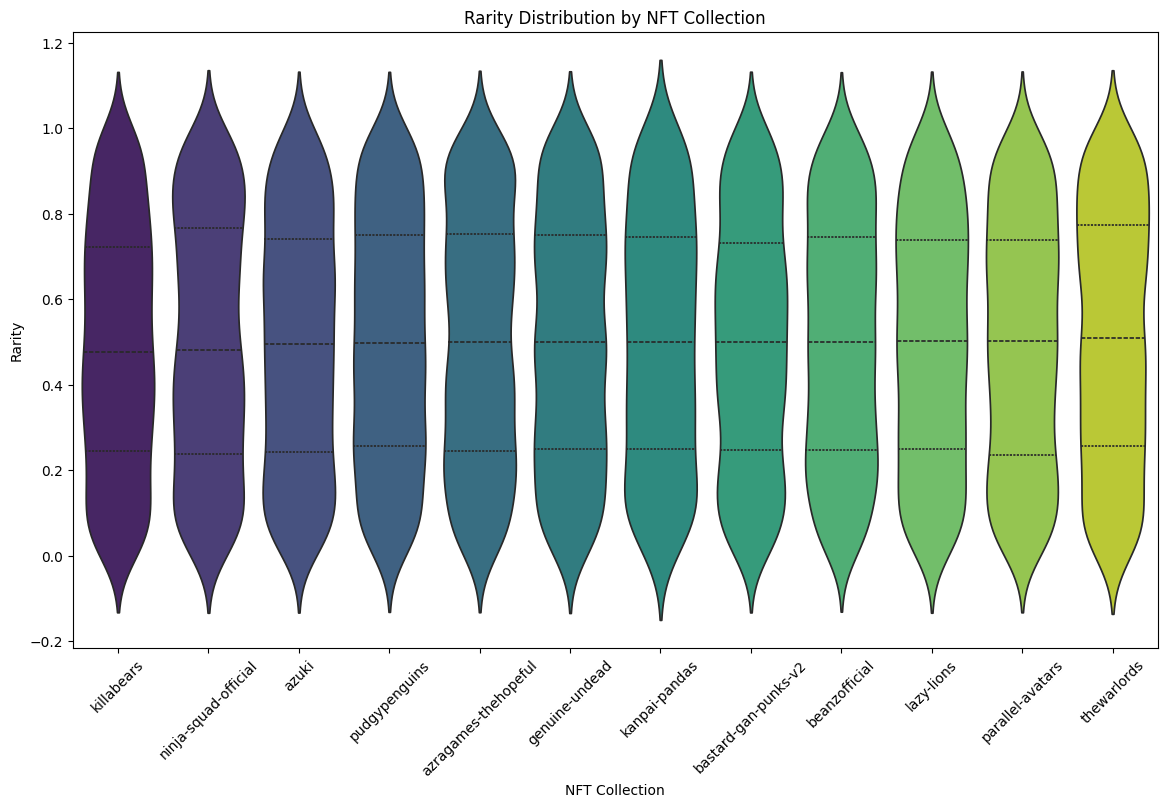

Thresholds for each collection:
collection_name
azragames-thehopeful    0.054097
azuki                   0.052990
bastard-gan-punks-v2    0.050203
beanzofficial           0.056515
genuine-undead          0.053155
kanpai-pandas           0.056037
killabears              0.041689
lazy-lions              0.051410
ninja-squad-official    0.049296
parallel-avatars        0.046999
pudgypenguins           0.057264
thewarlords             0.043499
Name: rarity, dtype: float64


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a dictionary label_dist with rarity data
# Replace 'label_dist' with the actual dictionary variable
# valid_list is assumed to be a list of collection names

# Create an empty DataFrame to store the data
df = pd.DataFrame(columns=['collection_name', 'rarity'])

# Populate the DataFrame with data from label_dist
for col_name, rarity_values in label_dist.items():
    df = pd.concat([df, pd.DataFrame({'collection_name': [col_name] * len(rarity_values), 'rarity': rarity_values})])

# Create a violin plot to visualize the rarity distribution for each collection
plt.figure(figsize=(14, 8))
sns.violinplot(x='collection_name', y='rarity', data=df, palette="viridis", inner="quartile", order=df.groupby('collection_name')['rarity'].median().sort_values().index)
plt.title('Rarity Distribution by NFT Collection')
plt.xlabel('NFT Collection')
plt.ylabel('Rarity')
plt.xticks(rotation=45)
plt.show()

# Calculate the 5th percentile as a threshold for rare items for each collection
thresholds = df.groupby('collection_name')['rarity'].quantile(0.05)

# Print the thresholds for each collection
print("Thresholds for each collection:")
print(thresholds)

In [85]:
thresholds['azuki']

0.05299

In [86]:
1500 * 5

7500

In [87]:
for col_name in valid_list:
    new_l = []
    new_l = [x for x in label_dist[col_name] if x <= thresholds[col_name]]
    if len(new_l) > 0:
        print(f"{col_name}: {len(new_l)}:  {sorted(new_l)[0]}")

azuki: 75:  0.0003
killabears: 75:  0.00030003000300030005
lazy-lions: 71:  0.00010003000900270081
genuine-undead: 75:  0.00010017028949213663
bastard-gan-punks-v2: 75:  0.000530832522339202
pudgypenguins: 75:  0.0014629754670267836
beanzofficial: 75:  0.001153113406196731
ninja-squad-official: 75:  0.0032653980407611753
azragames-thehopeful: 75:  0.0032485110990795887
thewarlords: 75:  0.0006000600060006001
parallel-avatars: 75:  0.001363884342607747
kanpai-pandas: 32:  0.010717347813661047


In [88]:
df_labels = pd.read_csv(labels_dir)

In [89]:
df_labels.dropna(inplace=True)

In [90]:
len(df_labels)

17042

In [91]:
label_dist

{'azuki': [0.3476,
  0.1719,
  0.9093,
  0.2025,
  0.6889,
  0.6688,
  0.1211,
  0.3703,
  0.0245,
  0.512,
  0.6101,
  0.1252,
  0.8424,
  0.8454,
  0.8717,
  0.1823,
  0.4062,
  0.4101,
  0.718,
  0.3435,
  0.7581,
  0.8154,
  0.0604,
  0.6233,
  0.4444,
  0.7213,
  0.0844,
  0.2555,
  0.1765,
  0.7024,
  0.9345,
  0.2029,
  0.4407,
  0.8838,
  0.8873,
  0.0563,
  0.4446,
  0.2743,
  0.0351,
  0.6778,
  0.9955,
  0.0535,
  0.9443,
  0.2262,
  0.1475,
  0.1879,
  0.1334,
  0.9512,
  0.1482,
  0.5139,
  0.9654,
  0.4691,
  0.2556,
  0.6355,
  0.4156,
  0.2887,
  0.6018,
  0.2877,
  0.5795,
  0.0278,
  0.8068,
  0.4303,
  0.6223,
  0.7967,
  0.4751,
  0.2302,
  0.6985,
  0.5788,
  0.0361,
  0.9578,
  0.3713,
  0.3187,
  0.6462,
  0.5944,
  0.8802,
  0.4091,
  0.3647,
  0.7033,
  0.6674,
  0.5068,
  0.4838,
  0.2539,
  0.7352,
  0.7744,
  0.6659,
  0.0094,
  0.5539,
  0.2941,
  0.4182,
  0.5805,
  0.5562,
  0.6915,
  0.4715,
  0.0766,
  0.6449,
  0.4667,
  0.182,
  0.5307,
  0.5495,
  0.

In [ ]:
rarity_dataset.labels['cls'] = 0

In [100]:
for inst in range(len(rarity_dataset)):
    img, label = rarity_dataset[inst]
    rarity_dataset.labels['cls'][inst] = 1 if label <= thresholds[rarity_dataset.col_name] else 0

/tmp/ipykernel_5118/1165131637.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rarity_dataset.labels['cls'][inst] = 1 if label <= thresholds[rarity_dataset.col_name] else 0
/tmp/ipykernel_5118/1165131637.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rarity_dataset.labels['cls'][inst] = 1 if label <= thresholds[rarity_dataset.col_name] else 0
/tmp/ipykernel_5118/1165131637.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ra

In [108]:
rarity_dataset.labels

index                      data_name  \
0          0  ninja-squad-official_8870.png   
1          1  ninja-squad-official_8869.png   
2          2  ninja-squad-official_8868.png   
3          3  ninja-squad-official_8867.png   
4          4  ninja-squad-official_8866.png   
...      ...                            ...   
17037  22414            killabears_1789.png   
17038  22415            killabears_1819.png   
17039  22416            killabears_1848.png   
17040  22417            killabears_1788.png   
17041  22418            killabears_1818.png   

                                                   label  \
0      {'strategy_id': None, 'strategy_version': None...   
1      {'strategy_id': None, 'strategy_version': None...   
2      {'strategy_id': None, 'strategy_version': None...   
3      {'strategy_id': None, 'strategy_version': None...   
4      {'strategy_id': None, 'strategy_version': None...   
...                                                  ...   
17037  {'strategy_id': None, 'strategy_version': None...   
17038  {'strategy_id': None, 'strategy_version': None...   
17039  {'strategy_id': None, 'strategy_version': None...   
17040  {'strategy_id': None, 'strategy_version': None...   
17041  {'strategy_id': None, 'strategy_version': None...   

                                                    dict  rank_values  cls  
0      {'strategy_id': None, 'strategy_version': None...       7008.0    0  
1      {'strategy_id': None, 'strategy_version': None...       2608.0    0  
2      {'strategy_id': None, 'strategy_version': None...       5465.0    0  
3      {'strategy_id': None, 'strategy_version': None...       7386.0    0  
4      {'strategy_id': None, 'strategy_version': None...       5917.0    0  
...                                                  ...          ...  ...  
17037  {'strategy_id': None, 'strategy_version': None...       2386.0    0  
17038  {'strategy_id': None, 'strategy_version': None...         12.0    1  
17039  {'strategy_id': None, 'strategy_version': None...       1681.0    0  
17040  {'strategy_id': None, 'strategy_version': None...       1864.0    0  
17041  {'strategy_id': None, 'strategy_version': None...        602.0    0  

[17042 rows x 6 columns]